<a href="https://colab.research.google.com/github/Dicere/Machine_Learning_algorithms_from_scratch/blob/main/Tree_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
from sklearn.datasets import load_diabetes
data = load_diabetes(as_frame=True)
X, y = data['data'], data['target']

In [19]:
class MyTreeReg():
    def __init__(self, max_depth=5, min_samples_split=2,max_leafs=2,bins=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.bins = bins
        self.leafs_cnt = 0
        self.tree_dict = {}
        self.depths_numb={}
        self.node_count = 0
        self.fi={}
    def __str__(self):
        attributes = ', '.join(f"{key}={value}" for key, value in vars(self).items())
        return f"MyTreeClf class: {attributes}"
    def __repr__(self):
        attributes = ', '.join(f"{key}={value}" for key, value in vars(self).items())
        return f"MyTreeClf class: {attributes}"

    def evristic(self,y):
      n = y.shape[0]
      if n == 0:
        return 0
      s = 1/n*(np.sum((y-np.mean(y))**2))
      return s


    def get_best_split(self,X,y):
      n_cols = X.shape[1]
      s0 = self.evristic(y)
      ig_max=0
      col_name=""
      split_value=np.float()

      for i in range(n_cols):
        if self.bins is not None:
          splits_feature =  self.splits_list[i]
        else:
          feature_values = np.sort(X.iloc[:,i].unique())
          splits_feature = [(feature_values[idx]+feature_values[idx+1])/2 for idx in range(len(feature_values)-1)]

        ig = 0
        for split_val in splits_feature:

            idx_right = X[np.all([X.iloc[:,i] > split_val], axis=0)].index
            idx_left = X[np.all([X.iloc[:,i] <= split_val], axis=0)].index
            ig = s0 - ((len(idx_left)/len(y))*self.evristic(y.loc[idx_left])) - ((len(idx_right)/len(y))*self.evristic(y.loc[idx_right]))

            if ig > ig_max:
                ig_max=ig
                col_name=X.iloc[:,i].name
                split_value = split_val
      return col_name, split_value, ig_max

    def node_or_list(self, y,curr_depth):
      if y.shape[0] <= 1:
        # print('1 семпл')
        return False
      elif self.max_depth ==curr_depth:
        # print('Макс глубина')
        return False
      elif self.max_leafs <=2:
        # print('Меньше 1 листа быть не может')
        return False
      elif self.min_samples_split >y.shape[0]:
        # print('Минимальное возможное количетсво элементов для разбиения')
        return False
      else:
        if self.node_count!=0:
          return True

    def calc_bins_and_splits(self,X):
        n_cols = X.shape[1]
        self.splits_list=[]
        for i in range(n_cols):
          feature_values = np.sort(X.iloc[:,i].unique())
          if len(feature_values)-1 <= self.bins-1:
            splits_feature = [(feature_values[idx]+feature_values[idx+1])/2 for idx in range(len(feature_values)-1)]
          else:
             splits_feature = np.histogram(feature_values, bins=self.bins)[1][1:-1]
          self.splits_list.append(splits_feature)

    def add_leaf(self,curr_depth,leaf_name,leaf):

          if curr_depth in self.tree_dict.keys():
            pred = np.mean(y.loc[leaf])
            self.tree_dict[curr_depth].append([pred])
          else:
            pred = np.mean(y.loc[leaf])
            self.tree_dict[curr_depth] = []
            self.tree_dict[curr_depth].append([pred])
          self.leafs_cnt += 1

    def iter_for_feature(self,X,y,curr_depth=0):
        col_name, split_val, ig = self.get_best_split(X,y)
        leaf_left = X[np.all([X.loc[:,col_name] <= split_val], axis=0)].index
        leaf_right = X[np.all([X.loc[:,col_name] > split_val], axis=0)].index
        self.fi[col_name]+=(X.shape[0]/self.number_rows)*ig

        if curr_depth in self.tree_dict.keys():
          if curr_depth in self.depths_numb.keys():
            self.tree_dict[curr_depth].append([col_name, split_val,self.depths_numb[curr_depth],self.depths_numb[curr_depth]+1])
            self.depths_numb[curr_depth] +=2
          else:
            self.depths_numb[curr_depth] = 0
            self.tree_dict[curr_depth].append([col_name, split_val,self.depths_numb[curr_depth],self.depths_numb[curr_depth]+1])
            self.depths_numb[curr_depth] +=2
        else:
          self.depths_numb[curr_depth] = 0
          self.tree_dict[curr_depth] = []
          self.tree_dict[curr_depth].append([col_name, split_val,self.depths_numb[curr_depth],self.depths_numb[curr_depth]+1])
          self.depths_numb[curr_depth] +=2

        curr_depth +=1
        if self.node_or_list(y.loc[leaf_left],curr_depth):
          self.node_count-=1
          self.iter_for_feature(X.loc[leaf_left],y.loc[leaf_left],curr_depth)
        else:
          self.add_leaf(curr_depth,"leaf_left",leaf_left)
        if self.node_or_list(y.loc[leaf_right],curr_depth):
          self.node_count-=1
          self.iter_for_feature(X.loc[leaf_right],y.loc[leaf_right],curr_depth)
        else:
          self.add_leaf(curr_depth,"leaf_right",leaf_right)

    def fit(self, X_fit: pd.DataFrame, y_fit: pd.Series):
      X = X_fit.copy()
      y = y_fit.copy()
      if self.bins is not None:
          self.calc_bins_and_splits(X)
      self.fi=dict.fromkeys(X.columns,0)
      self.number_rows=X.shape[0]
      self.node_count = self.max_leafs-2
      self.iter_for_feature(X,y)
      return self.tree_dict

    def pred(self,x,i,c):
      if len(self.tree_dict[i][c]) != 1:
        uslovie = self.tree_dict[i][c][1]
        column = self.tree_dict[i][c][0]
        idx_left_leaf=self.tree_dict[i][c][2]
        idx_right_leaf= self.tree_dict[i][c][3]
        if x[column] <= uslovie:
          i+=1
          return self.pred(x,i,idx_left_leaf)
        else:
          i+=1
          return self.pred(x,i,idx_right_leaf)
      else:
        return self.tree_dict[i][c][-1]

    def predict(self, X_test: pd.DataFrame):
        X = X_test.copy()
        y_pred_vec = X.apply(lambda x: self.pred(x,0,0),axis=1)
        return y_pred_vec




In [16]:
params = {"max_depth": 3, "min_samples_split": 2, "max_leafs": 1, "bins": 10}

In [17]:
instance = MyTreeReg(**params)

In [18]:
tree_dict = instance.fit(X,y)

<ipython-input-15-5e663e156483>:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split_value=np.float()


In [13]:
tree_dict

{0: [['bmi', 0.014056912853151957, 0, 1]],
 1: [[122.76223776223776], [205.98076923076923]]}

In [14]:
sum(instance.predict(X))

67242.99999999997

In [ ]:
import graphviz
class TreeNode:
    def __init__(self, value, left=None, right=None):
        self.is_leaf = len(value) == 1  # Лист содержит только один элемент
        self.value = value
        self.left = left
        self.right = right


def build_tree(tree_dict):
    nodes = {0: [TreeNode(tree_dict[0][0])]}

    for depth in range(1, max(tree_dict.keys())+1):
        nodes[depth] = []
        i = 0
        while i < len(tree_dict[depth]):
            for parent_node in nodes[depth-1]:
                if parent_node.is_leaf:
                    # Если родитель является листом, он не может иметь детей, поэтому пропускаем его.
                    continue
                left = TreeNode(tree_dict[depth][i])
                right = TreeNode(tree_dict[depth][i+1]) if i+1 < len(tree_dict[depth]) else None
                parent_node.left = left
                parent_node.right = right
                nodes[depth].extend([left, right])
                i += 2  # Переходим к следующей паре узлов на текущей глубине.
                if i >= len(tree_dict[depth]):  # Прерываем цикл, если больше нет узлов.
                    break
    return nodes[0][0]  # Возвращаем корень дерева

def add_edges(graph, node, parent_name=""):
    if node is not None:
        node_name = parent_name + str(node.value)
        graph.node(node_name, label=str(node.value))
        if parent_name:
            graph.edge(parent_name, node_name)
        add_edges(graph, node.left, node_name)
        add_edges(graph, node.right, node_name)

def visualize_tree(root):
    dot = graphviz.Digraph()
    add_edges(dot, root)
    return dot




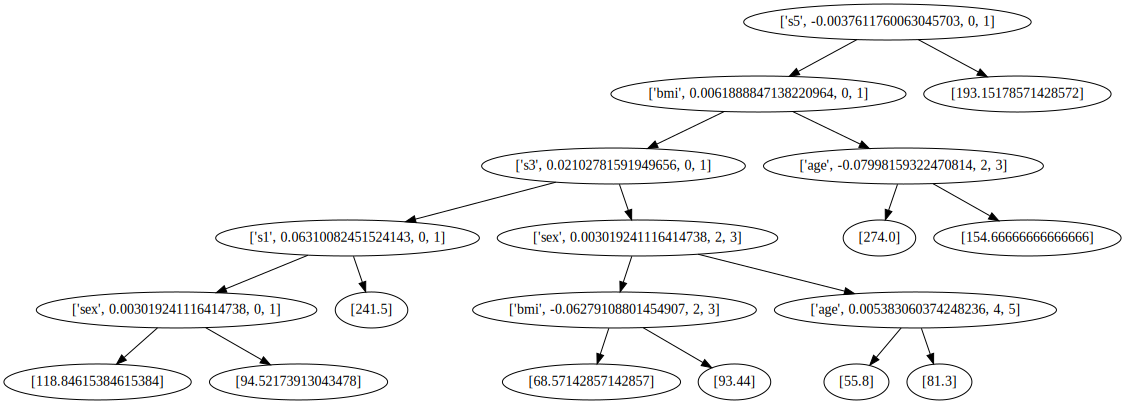

In [ ]:
root = build_tree(tree_dict)
visualize_tree(root)

In [ ]:
def print_tree(node, indent="", side="root"):
    if node.is_leaf:
        if side == "left":
            print(f"{indent}leaf_left = {node.value[0]}")
        elif side == "right":
            print(f"{indent}leaf_right = {node.value[0]}")
    else:
        print(f"{indent}{node.value[0]} > {node.value[1]}")
        print_tree(node.left, indent + "  ", "left")
        if node.right is not None:
            print_tree(node.right, indent + "  ", "right")

In [ ]:
root = build_tree(tree_dict)
print_tree(root)

s5 > -0.0037611760063045703
  bmi > 0.0061888847138220964
    s3 > 0.02102781591949656
      s1 > 0.06310082451524143
        sex > 0.003019241116414738
          leaf_left = 118.84615384615384
          leaf_right = 94.52173913043478
        leaf_right = 241.5
      sex > 0.003019241116414738
        bmi > -0.06279108801454907
          leaf_left = 68.57142857142857
          leaf_right = 93.44
        age > 0.005383060374248236
          leaf_left = 55.8
          leaf_right = 81.3
    age > -0.07998159322470814
      leaf_left = 274.0
      leaf_right = 154.66666666666666
  leaf_right = 193.15178571428572
